# Understanding the Fourier Transform by example
How to implement the Fast Fourier Transform algorithm in Python from scratch. <br />
@author: Simon J. Buehrer <br />
@date: 2021-02-04 <br /><br />
**Links:**
<ul>
<li> https://towardsdatascience.com/fast-fourier-transform-937926e591cb </li>
<li> https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/ </li>
<li> https://towardsdatascience.com/analyzing-seasonality-with-fourier-transforms-using-python-scipy-bb46945a23d3 </li>
</ul> 

In [260]:
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
import datetime as dt 

import yfinance as yf #pip install yfinance /or pip3 /or conda
import numpy as np
import statsmodels.api as sm
from scipy.signal import find_peaks

# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 

import math



## get data

In [261]:
#get current day and download hist. data 
today = dt.datetime.today().strftime('%Y-%m-%d')
hist = (dt.datetime.today()-dt.timedelta(10000)).strftime('%Y-%m-%d')

stockname='ABB'
print(today,hist)
stockdata_df = yf.download(stockname, start=hist, end=today)
print(stockdata_df.tail(5))

2021-02-06 1993-09-21
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-02-01  29.790001  30.160000  29.660000  30.139999  30.139999  1500400
2021-02-02  30.160000  30.520000  30.120001  30.469999  30.469999  1678900
2021-02-03  30.459999  30.639999  30.389999  30.559999  30.559999  1778900
2021-02-04  29.110001  29.129999  28.760000  29.020000  29.020000  4598100
2021-02-05  28.900000  28.990000  28.700001  28.820000  28.820000  1711400


## Calculating the difference (OLS)
und e neui column dezue tue wel datum müesam isch

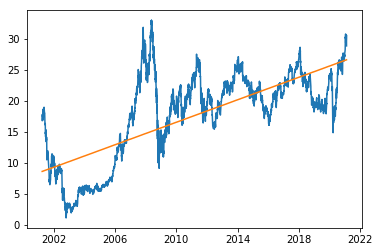

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     5404.
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        13:51:08   Log-Likelihood:                -15094.
No. Observations:                4990   AIC:                         3.019e+04
Df Residuals:                    4988   BIC:                         3.021e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6221      0.141     61.113      0.0

In [262]:
stockdata_df['row_num'] = np.arange(len(stockdata_df))
X = sm.add_constant(stockdata_df['row_num']) 
model = sm.OLS(stockdata_df['Close'], X).fit()
stockdata_df['OLS'] = model.predict(X) 

plt.plot(stockdata_df.index,stockdata_df['Close']) 
plt.plot(stockdata_df.index,stockdata_df['OLS'])
plt.show() 
print(model.summary())

stockdata_df['Diff']=stockdata_df['Close']-stockdata_df['OLS']

## es paar Diagramm
Afoch welis chan

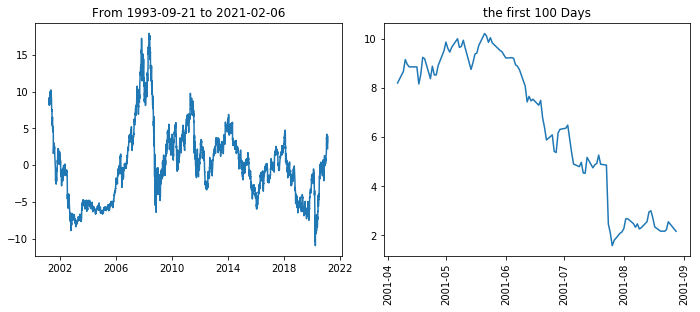

In [263]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index,stockdata_df['Diff']) 
ax1.set_title("From " + hist + " to " +today)

N=100
ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index[:N],stockdata_df['Diff'][:N]) 
ax2.set_title("the first " + str(N) +" Days")

plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

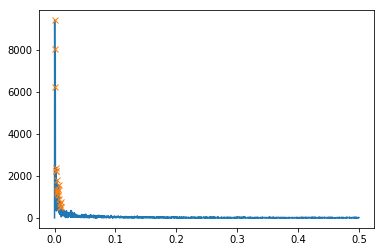

18


In [264]:
fft_output = np.fft.fft(stockdata_df['Diff'])
power = np.abs(fft_output)
freq = np.fft.fftfreq(len(stockdata_df['Diff']))

# mask susch au negativi drinää
mask = freq >= 0
freq = freq[mask]
power = power[mask]

peaks, _ = find_peaks(power[freq >=0], height=500)

plt.plot(freq,power)
plt.plot(freq[peaks], power[peaks],'x')
plt.show() 
print(len(peaks))


In [265]:
output = pd.DataFrame()
output['index'] = peaks
output['freq'] = freq[peaks]
output['amplitude'] = power[peaks]
output['fft'] = fft_output[peaks]
output = output.sort_values('amplitude', ascending=False)

output.head()

,index,freq,amplitude,fft
0,1,0.000200,9412.040860,-9410.418220-174.762960j
2,6,0.001202,8025.070541,8009.031732+507.117249j
1,3,0.000601,6242.954229,6240.278917-182.747217j
5,14,0.002806,2381.959209,2378.885721+120.964447j
3,10,0.002004,2236.526626,-1277.582068-1835.711146j


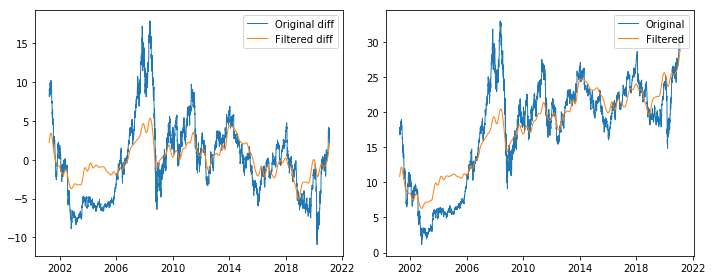

In [266]:
filtered_fft_output = np.array([f if i in list(output['index']) else 0 for i, f in enumerate(fft_output)])
filtered_diff = np.fft.ifft(filtered_fft_output)

stockdata_df['Filtered']=stockdata_df['OLS']+filtered_diff

plt.figure(figsize=(10, 4))
ax1 = plt.subplot( 1, 2, 1 )
ax1.plot(stockdata_df.index, stockdata_df['Diff'], linewidth=1, label='Original diff')
ax1.plot(stockdata_df.index, filtered_diff.real, linewidth=1, label='Filtered diff')
ax1.legend(loc='upper right')

ax2 = plt.subplot( 1, 2, 2 )
ax2.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original')
ax2.plot(stockdata_df.index, stockdata_df['Filtered'], linewidth=1, label='Filtered')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Incorporating into our regression

The problem with these sinusoids is that the amplitude is off!

In [267]:
from cmath import phase

fourier_terms = pd.DataFrame()
fourier_terms['fft'] = output['fft']
fourier_terms['freq'] = output['freq']
fourier_terms['amplitude'] = fourier_terms.fft.apply(lambda z: abs(z)) 
fourier_terms['phase'] = fourier_terms.fft.apply(lambda z: phase(z))
fourier_terms.sort_values(by=['amplitude'], ascending=[0])

# Create some helpful labels (FT_1..FT_N)
fourier_terms['label'] = list(map(lambda n : 'FT_{}'.format(n), range(1, len(fourier_terms) + 1)))

# Turn our dataframe into a dictionary for easy lookup
fourier_terms = fourier_terms.set_index('label')
fourier_terms_dict = fourier_terms.to_dict('index')

fourier_terms.head()

,fft,freq,amplitude,phase
label,,,,
FT_1,-9410.418220-174.762960j,0.000200,9412.040860,-3.123024
FT_2,8009.031732+507.117249j,0.001202,8025.070541,0.063234
FT_3,6240.278917-182.747217j,0.000601,6242.954229,-0.029277
FT_4,2378.885721+120.964447j,0.002806,2381.959209,0.050805
FT_5,-1277.582068-1835.711146j,0.002004,2236.526626,-2.178806


In [268]:
for key in fourier_terms_dict.keys():
    a = fourier_terms_dict[key]['amplitude']
    w = 2 * math.pi * (fourier_terms_dict[key]['freq'])
    p = fourier_terms_dict[key]['phase']
    stockdata_df[key] = stockdata_df['row_num'].apply(lambda t: a * math.cos(w*t + p))

stockdata_df['FT_All'] = 0
for column in list(fourier_terms.index):
    stockdata_df['FT_All'] = stockdata_df['FT_All'] + stockdata_df[column]


# Sample 
stockdata_df[['Close', 'row_num', 'FT_All']  + list(fourier_terms.index)].head()

,Close,row_num,FT_All,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,...,FT_9,FT_10,FT_11,FT_12,FT_13,FT_14,FT_15,FT_16,FT_17,FT_18
Date,,,,,,,,,,,,,,,,,,,,,
2001-04-06,16.828125,0,11113.666145,-9410.418220,8009.031732,6240.278917,2378.885721,-1277.582068,1206.611107,1399.861376,...,831.147351,-1138.003027,948.185081,1051.567486,-172.963484,391.720072,168.353784,-647.304338,83.535105,-429.323983
2001-04-09,17.299999,1,11455.614463,-9410.190706,8004.971967,6240.924715,2376.383837,-1254.366946,1234.717225,1424.740435,...,874.185808,-1116.476813,969.936604,1067.500616,-134.319438,427.623015,212.963182,-640.859097,121.778011,-445.307980
2001-04-10,17.790001,2,11792.618822,-9409.948273,8000.455305,6241.481459,2373.143504,-1230.952950,1262.541452,1448.966701,...,915.892492,-1093.754089,991.073036,1082.614632,-95.508449,462.647440,256.762147,-632.535612,159.393883,-459.798448
2001-04-11,17.600000,3,12124.057733,-9409.690920,7995.482003,6241.949143,2369.165729,-1207.343793,1290.077436,1472.529073,...,956.203863,-1069.859208,1011.580975,1096.897936,-56.578755,496.721393,299.584000,-622.358278,196.189038,-472.746789
2001-04-12,17.500000,4,12449.315883,-9409.418649,7990.052344,6242.327758,2364.451749,-1183.543217,1317.318891,1495.416756,...,995.058510,-1044.817775,1031.447413,1110.339570,-17.578739,529.774872,341.265783,-610.356922,231.974018,-484.109575


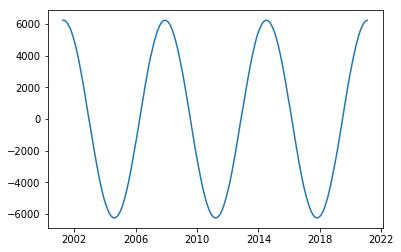

In [269]:
plt.plot(stockdata_df.index, stockdata_df['FT_3'])
plt.show()

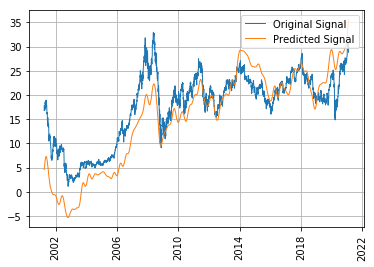

                                 OLS Regression Results                                
Dep. Variable:                  Close   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                          3.490e+04
Date:                Sat, 06 Feb 2021   Prob (F-statistic):                        0.00
Time:                        13:51:10   Log-Likelihood:                         -15022.
No. Observations:                4990   AIC:                                  3.005e+04
Df Residuals:                    4988   BIC:                                  3.006e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [270]:
X = pd.DataFrame(stockdata_df[['row_num','FT_All']]) 
y = pd.DataFrame(stockdata_df['Close'])

model = sm.OLS(y, X).fit()
y_predict = model.predict(X) 

plt.plot(stockdata_df.index, stockdata_df['Close'], linewidth=1, label='Original Signal')
plt.plot(stockdata_df.index, y_predict, linewidth=1, label='Predicted Signal')
plt.legend(loc='upper right')
plt.grid()
plt.xticks(rotation=90)
plt.show()

print(model.summary())